# A Sinkhorn-type Algorithm for Constrained Optimal Transport

This tutorial aims to reproduce key experiments from the paper [A Sinkhorn-type Algorithm for Constrained Optimal Transport](https://openreview.net/pdf?id=V5kCKFav9j) using the OTT-JAX library. We will extend its basic Sinkhorn solvers to handle the paper's additional **linear constraints** (both equalities and inequalities) and verify that the exponential convergence if guaranteed.

In this setting, constrained OT problems can be described as follows:

Starting from two probability vectors
$$
r,\;c\in\Delta^n,
\quad
\sum_{i=1}^n r_i \;=\;\sum_{j=1}^n c_j \;=\;1,
$$
and a cost matrix $ C \in \mathbb{R}^{n \times n} $. In addition, we are given:
- $ K $ **inequality constraints** of the form $ D_k \cdot P \ge t_k $.
- $ L $ **equality constraints** of the form $ D_{K+l} \cdot P = t_{K+l} $
where each $ D_i \in \mathbb{R}^{n \times n} $ encodes one linear functional on the plan $ P $. By shifting each inequality ($ \tilde{D_i} = D_i - t_i*\textbf{1}_{n\times n}$), we can write the following:

$$
\mathcal{I}
\;=\;
\bigcap_{k=1}^K
\bigl\{P\in\mathbb{R}_+^{n\times n}\;\big|\;(D_k - t_k\mathbf{1}_{n\times n})\!\cdot\!P \;\ge\;0\},
\quad
\mathcal{E}
\;=\;
\bigcap_{\ell=1}^L
\bigl\{P\in\mathbb{R}_+^{n\times n}\;\big|\;D_{K+\ell}\!\cdot\!P \;=\;0\}.
$$.

The feasible set of transport plans is then given by $ \mathcal{S} = \mathcal{I} \cap \mathcal{E} $.

## Importing the modules

In [ ]:
# %pip install -q git+https://github.com/ott-jax/ott@main

In [ ]:
import numpy as np
from scipy.stats import gaussian_kde as kde
import jax
import jax.numpy as jnp

from tqdm import tqdm
import optax

import matplotlib.pyplot as plt

In [3]:
import seaborn as sns

## Experiment: Random Assignment with Gaussian Marginals and Linear Constraints

In this experiment, we follow the "random assignement under constraints" setup from the paper, with non-uniform marginals to better illustrate the effect of entropic regularization and constraints. Concretely:

1. **Gaussian-mixture source**:
    We generate the source histogram
    $$
    c = \mathrm{sort} \Bigl ( \bigl[\,0.5\cdot\mathcal N(-2,0.6^2) \bigr]_{i=1}^{n/2} \; \big \| \; \bigl[\,0.5 \cdot \mathcal N(4,0.3^2) \bigr]_{i=1}^{n/2}\Bigr) \,/ \, \sum_i c_i,
    $$
    so that half of the mass sits near -2 and half near 4, then sorted and normalized to $ \sum_i c_i=1 $. This creates a **bimodal** distribution whose shape will highlight how constraints steer mass between clusters.

2. **Gausian targets**:
    The target $ r $ is drawn as $ \displaystyle r_i \propto \exp \bigl (- \tfrac{(x_i-1)^2}{2 \times 0.5^2} \bigr ) $, sorted and normalized, placing all mass around $ x = 1 $.

3. **Random cost matrix**  
   We sample $ C_{ij} \sim \mathrm{Unif}(0,1) $, then **skew** the bottom-right quadrant by a factor of 1.5 (and the rest by 0.5) to break symmetry and force nontrivial transport paths.

4. **Linear constraints**  
   The paper recommends choosing thresholds 
   $ \displaystyle t_I=\tfrac1n\sum_{i,j}D^I_{ij} $ and $ \displaystyle t_E=\tfrac1n\sum_{i,j}D^E_{ij} $
   so that the feasibility set is nonempty.

   For simplicity we fix $ t_I=t_E=0.5 $, sample $ D^I, D^E\sim\mathrm{Unif}(0,1)^{n\times n} $, and then **shift and scale**  
   $$
     D_1 = \frac{D^I - t_I\, \mathbb{A}}{n},\quad
     D_2 = \frac{D^E - t_E\,\mathbb{A}}{n},
   $$
   where $ \mathbb{A} = \mathbf1\mathbf1^\top = \textbf{1}_{n\times n}$ 
   so that both $ D_k\!\cdot\!P\ge0 $ fit the form in equation (13) of the paper. Dividing by $ n $ also guarantees $ \|D_k\|_\infty\le1 $, a key hypothesis in Theorem 1’s exponential error bound.


In [4]:
# Problem dimensions and regularization
n = 30  # small problem size to reduce computation time
eta = 50.0  # strong entropic regularization
num_iter = 40  # number of iterations

one = jnp.ones((n, 1))

key = jax.random.PRNGKey(2147483647)
k1, k2, k3, k4, k5 = jax.random.split(key, num=5)

# Source c: mixture of two Gaussians at -2 and 4, normalized
c1 = 0.5 * (-2 + 0.6 * jax.random.normal(k1, (n // 2, 1)))
c2 = 0.5 * (4 + 0.3 * jax.random.normal(k3, (n // 2, 1)))
c = jnp.vstack([c1, c2])
c = jnp.sort(c)  # sorted
c /= jnp.sum(c)  # normalized

# Target r: single Gaussian around 1
r = jnp.sort(1 + 0.5 * jax.random.normal(k2, (n, 1)))
r /= jnp.sum(r)  # normalized

# Cost matrix C:
#    - Uniform costs in [0,1]
#    - Bottom right corner has higher costs (3x)
#    - Aims to create contrast between the two regions

C = jax.random.uniform(k3, (n, n))
mask = (jnp.arange(n)[:, None] > n // 2) & (jnp.arange(n)[None, :] > n // 2)
C = jnp.where(mask, 3 * C, C)


# Linear Constraints: random D^I, D^E with fixed thresholds
#    - Sample D^I and D^E uniformly in [0,1]
#    - tI = tE = 0.5 ensures a non-empty feasible set by symmetry
DI = jax.random.uniform(key=k4, minval=0.0, maxval=1.0, shape=(n, n))
DE = jax.random.uniform(key=k5, minval=0.0, maxval=1.0, shape=(n, n))
tI, tE = 0.5, 0.5
A = one @ one.T
D1 = (DI - tI * A) / n
D2 = (DE - tE * A) / n

### Costs, Source and Target visualization

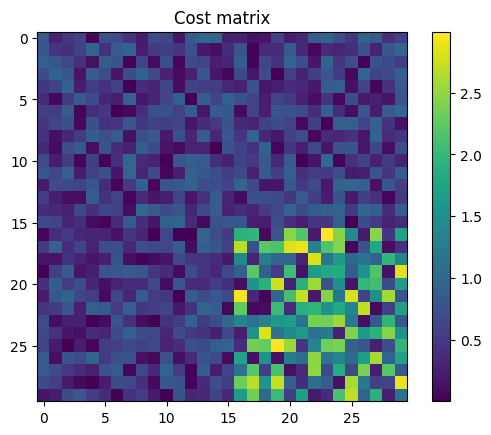

In [5]:
plt.title("Cost matrix")
plt.imshow(C)
plt.colorbar()

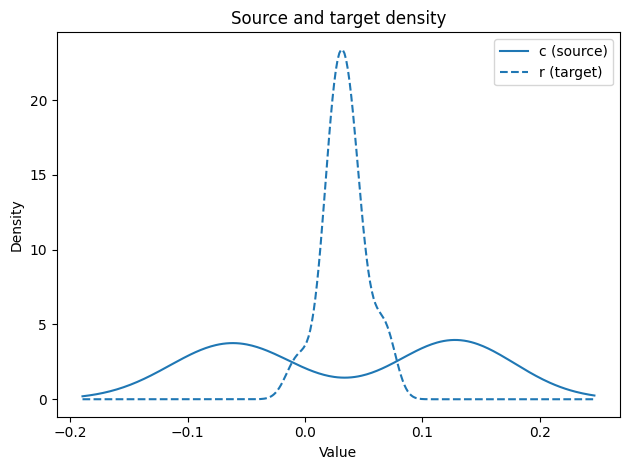

In [6]:
c_vals = np.array(c).flatten()
r_vals = np.array(r).flatten()

# build KDEs
c_kde = kde(c_vals)
r_kde = kde(r_vals)

# evaluation grid
xmin = min(c_vals) - 0.1
xmax = max(c_vals) + 0.1
xs = np.linspace(xmin, xmax, 300)

# plot the curves
plt.plot(xs, c_kde(xs), "-", label="c (source)", color="C0")
plt.plot(xs, r_kde(xs), "--", label="r (target)", color="C0")

plt.title("Source and target density")
plt.xlabel("Value")
plt.ylabel("Density")
plt.legend()
plt.tight_layout()
plt.show()

## The Lyapunov function

The core of the Sinkhorn algorithm is the **dual Lyapunov** function from the paper, restated here for our constraints $ D_1 $ and $ D_2 $.

Let us recall that a Lyapunov function is defined as
$ f(x, y, a) = f_1(x, y, a) + f_2(x, y, a) + f_3(x, y, a) $ where
$$
f_1(x, y, a) = -\frac{1}{\eta}\sum_{ij}\exp\left(\eta(-C_{ij} \sum_{m=1}^{K+L}a_m(D_m)_{i,j} + x_i +y_j) -1  \right)
$$,
$$ f_2(x, y, a) = \sum_i x_i r_i + \sum_j y_j c_j $$
$$ f_3 = - \frac{1}{\eta}\sum_{k=1}^K\exp(-\eta a_k -1) $$

In our case:
- **$ f_1 $** is the entropic term, pulling in the matrix-exponential of the modified cost $ -C + a_0 D_1 + a_1 D_2 $.  
- **$ f_2 $** enforces the marginal constraints via the dual variables $ x,y $.  
- **$ f_3 $** penalizes violation of the two inequality constraints through their duals $a_0,a_1$.  

Maximizing $ f $ in $ (x,y,a) $ is equivalent to solving our entropically regularized, constrained OT problem. Next we implement this in JAX using:

1. `f(x,y,a)` returning a scalar.
2. A helper `f_at(a_t, x, y)` to bundle duals for gradient steps.
3. A JIT-compiled `loss_fn(params, x, y)` for use with Optax.

In [7]:
@jax.jit
def f(x: jnp.ndarray, y: jnp.ndarray, a: jnp.ndarray) -> jnp.ndarray:
    """
    Dual Lyapunov function f(x,y,a) for two constraints D1,D2.

    x: shape (n,1), dual for source marginals
    y: shape (n,1), dual for target marginals
    a: shape (2,1), duals for the 2 linear constraints
    """
    # unpack constraint multipliers
    a0 = a[0, 0]  # dual for D1
    a1 = a[1, 0]  # dual for D2

    # build the combined constraint matrix M = a0*D1 + a1*D2
    M = a0 * D1 + a1 * D2

    # entropic coupling term
    exponent = eta * (-C + M + x + y.T) - 1.0
    exp_term = jnp.exp(jnp.clip(exponent, -40.0, 40.0))
    f_1 = -(1.0 / eta) * jnp.sum(exp_term)

    # marginal enforcement
    f_2 = (x.T @ r)[0, 0] + (y.T @ c)[0, 0]

    # entropy on slack variables
    exp_a0 = jnp.exp(jnp.clip(-eta * a0 - 1.0, -40.0, 40.0))
    exp_a1 = jnp.exp(jnp.clip(-eta * a1 - 1.0, -40.0, 40.0))
    f_3 = -(1.0 / eta) * (exp_a0 + exp_a1)

    return f_1 + f_2 + f_3

In [8]:
def f_at(a_t: jnp.ndarray, x: jnp.ndarray, y: jnp.ndarray) -> jnp.ndarray:
    """
    Lifted version of f for Optax:
    - a_t: shape (2,) for [a0, a1].
    """
    # reshape [a0, a1] into (2,1) and call the core dual objective
    a_vec = a_t.reshape(2, 1)
    return f(x, y, a_vec)


@jax.jit
def loss_fn(a_t: jnp.ndarray, x: jnp.ndarray, y: jnp.ndarray) -> jnp.ndarray:
    """
    Loss function for Optax: we maximize f, so minimize -f_at.
    """
    return -f_at(a_t, x, y)

## Sinkhorn &harr; Newton Main Loop

We now implement the alternating updates on the dual variables $ (x, y, a) $:

1. **Sinkhorn-style scaling** for $ (x, y) $:
    - Compute  
    $$ 
       P = \exp \bigl( \eta (-C + a_0 D_1 + a_1 D_2 + x + y^T) - 1 \bigr)
    $$
   - Update  
    $$ 
       x \; \leftarrow \; x \; + \; \frac{1}{\eta} \Bigl ( \log r \;- \; \log \bigl (P \,\mathbf1 \bigr) \Bigr)
    $$
   - Recompute $ P $ with the new $ x $, then  
    $$ 
       y \; \leftarrow \; y \; + \; \frac{1}{\eta} \Bigl (\log c \; - \; \log \bigl (P^T \,\mathbf1 \bigr) \Bigr).
    $$
2. **Gradient ascent** on $ a $ to maximize $ f(x,y,a) $.  Equivalently, we minimize  
   $ \ell(a) = -f(x,y,a) $  
   via Adam with learning rate $ 10^{-2} $.

We also **track** at each iteration:
- **Max marginal error** $ \|P\,\mathbf1 - r\|_\infty $ and $ \|P^T\,\mathbf1 - c\|_\infty $,  
- **Constraint slacks** $ \sum_{i,j}(D_k)_{ij}\,P_{ij} $ for $ k=1,2 $.  

In [ ]:
N = num_iter  # number of outer iterations

# initialize duals x, y, a
x = jax.random.uniform(k2, minval=0.0, maxval=0.2, shape=(n, 1))
y = jax.random.uniform(k3, minval=0.0, maxval=0.1, shape=(n, 1))
key_a = jax.random.PRNGKey(1)
a = 1e-4 * jax.random.normal(key_a, (2, 1))

# pack a into a vector for Optax
a_t = a.flatten()
lr_a = 1e-5  # learning rate for a

# optimizer and state
optimizer = optax.adam(learning_rate=lr_a)
opt_state = optimizer.init(a_t)

clip_value = 100.0  # gradient clipping for stability

In [ ]:
# Main loop
for _ in tqdm(range(N), desc="Sinkhorn-Newton"):
    # Sinkhorn-style scaling for x
    first = jnp.array([1, 0]).reshape(2, 1)
    second = jnp.array([0, 1]).reshape(2, 1)
    a0 = (first.T @ a)[0, 0]
    a1 = (second.T @ a)[0, 0]
    M = a0 * D1 + a1 * D2

    expo = eta * (-C + M + x + y.T) - 1.0
    P = jnp.exp(jnp.clip(expo, -40.0, 40.0))
    P = jnp.clip(P, 1e-10)
    x += (jnp.log(jnp.clip(r, 1e-10)) - jnp.log(jnp.clip(P @ one, 1e-10))) / eta

    # Sinkhorn-style scaling for y
    expo = eta * (-C + M + x + y.T) - 1.0
    P = jnp.exp(jnp.clip(expo, -40.0, 40.0))
    P = jnp.clip(P, 1e-10)
    y += (
        jnp.log(jnp.clip(c, 1e-10)) - jnp.log(jnp.clip(P.T @ one, 1e-10))
    ) / eta

    # Gradient ascent on a_t (updates the duals a₀, a₁)
    for _ in range(500):
        loss_val, grads = jax.value_and_grad(loss_fn)(a_t, x, y)
        grads = jax.tree_util.tree_map(
            lambda g: jnp.clip(g, -clip_value, clip_value),
            grads,
        )
        updates, opt_state = optimizer.update(grads, opt_state)
        a_t = optax.apply_updates(a_t, updates)

    # unpack the new a and rebuild M
    a = jnp.reshape(jnp.array(a_t), (2, 1))
    a0 = float(a[0, 0])
    a1 = float(a[1, 0])
    M = a0 * D1 + a1 * D2

    # recompute the fully-scaled plan P
    expo = eta * (-C + M + x + y.T) - 1.0
    P = jnp.exp(jnp.clip(expo, -40.0, 40.0))
    P = jnp.clip(P, 1e-10)

# final transport plan
P_final = P

Sinkhorn-Newton: 100%|██████████| 40/40 [00:32<00:00,  1.22it/s]


## Visualization

### Final transport plan P

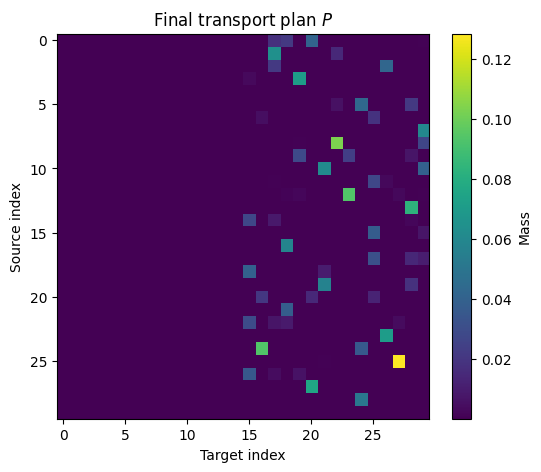

In [13]:
plt.figure(figsize=(6, 5))
plt.title("Final transport plan $P$")
plt.imshow(P_final, aspect="auto")
plt.colorbar(label="Mass")
plt.xlabel("Target index")
plt.ylabel("Source index")
plt.show()

### 1D Transport‐Plan Visualization

Below is a helper that takes:

- `x_src` (shape `(n_src,)`): 1D source locations  
- `x_tgt` (shape `(n_tgt,)`): 1D target locations  
- `P` (shape `(n_src, n_tgt)`): transport matrix  

It draws a line between each source–target pair with mass above `threshold`, with line opacity proportional to the transported mass.


In [14]:
def visualize_transport(x_src, x_tgt, P, threshold=1e-3):
    """
    Visualize a 1D transport plan P between source (y=0) and target (y=1),
    placing the legend to the right of the axes.
    """
    x_src = np.asarray(x_src).flatten()
    x_tgt = np.asarray(x_tgt).flatten()
    P = np.asarray(P)

    plt.figure(figsize=(10, 2))
    plt.scatter(
        x_src, np.zeros_like(x_src), color="blue", label="Source", zorder=3
    )
    plt.scatter(
        x_tgt, np.ones_like(x_tgt), color="red", label="Target", zorder=3
    )

    src_idx, tgt_idx = np.where(P > threshold)
    for i, j in zip(src_idx, tgt_idx):
        mass = P[i, j]
        alpha = float(mass * 100.0)
        alpha = min(alpha, 1.0)
        plt.plot(
            [x_src[i], x_tgt[j]], [0, 1], color="gray", alpha=alpha, linewidth=1
        )

    plt.yticks([0, 1], ["Source", "Target"])
    plt.legend(loc="center left", bbox_to_anchor=(1, 0.5))
    plt.title("Transport Map (1D)")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

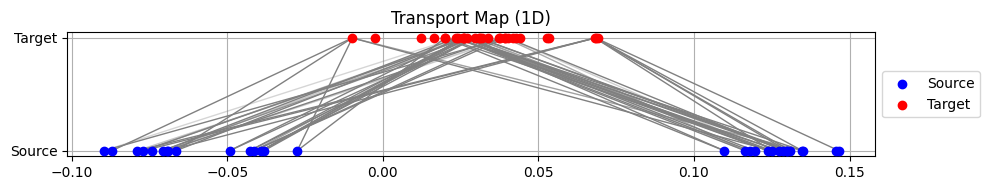

In [15]:
visualize_transport(
    np.array(c).flatten(),
    np.array(r).flatten(),
    np.array(P_final),
)

## Conclusion

In this tutorial, we have:

1. **Formulated** the entropically-regularized, constrained optimal transport problem  
   $ \min_{P\ge0}\langle C,P\rangle - \tfrac1\eta H(P) $  
   subject to marginal and extra linear constraints $ D_k\!\cdot\!P\ge0 $.

2. **Derived** and implemented the dual Lyapunov function  
   $ f(x,y,a) $
   and used JAX + Optax to perform alternating Sinkhorn updates on $ (x,y) $ and gradient steps on $ a $.

3. **Visualized** the final transport plan both as a heatmap and as a 1D transport map, using softmax-normalized intensities to highlight the most significant mass movements.
